In [1]:
import argparse
import sys
import os
import random
import time
import re
import copy
import pickle
import pandas as pd
import numpy as np

import gc
import torch
from torch import nn, optim, cuda
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader, RandomSampler, SequentialSampler, \
                             TensorDataset, WeightedRandomSampler

from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, precision_recall_fscore_support, roc_auc_score
from sklearn.model_selection import KFold

In [2]:
# from tqdm import tqdm|

from renet2.raw import load_documents
from renet2.raw_handler import *
from renet2.model import *

/autofs/bal31/jhsu/home/git/tmp/RENET2_b1/src/renet2/raw_handler.py:18: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [6]:
from renet2.train_renet2_ft_cv import *

In [7]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [8]:
import sys
sys.argv = ['']

if __name__ == "__main__":
    # set up
    parser = init_self_parser()
    args = parser.parse_args()
    
    sys.path.insert(0, 'renet2')
    get_index_path(args)
    
    
    use_cuda = torch.cuda.is_available() and not args.no_cuda
    device = torch.device('cuda' if use_cuda else 'cpu')
#     device = torch.device('cuda:1')

    torch.manual_seed(args.seed)

    if use_cuda:
        torch.cuda.manual_seed(args.seed)
    set_seed(args)
    args.device = device
    print('using device', device)

    args.ori_tokenizer = loading_tokenizer(args)
    args.token_voc_l = len(args.ori_tokenizer)
    print('tokenizer size %d' % (args.token_voc_l))
    
    args.batch_size = 32
    args.fix_snt_n, args.fix_token_n = 32, 54   
    
    print('fix input sentences# %d, tokens# %d, batch size %d' % (args.fix_snt_n, args.fix_token_n, args.batch_size))

using device cpu
loading word index from /autofs/bal31/jhsu/home/git/tmp/RENET2_b1/src/renet2/utils/word_index
loaded word index, voc size 82948
tokenizer size 82949
fix input sentences# 32, tokens# 54, batch size 32


In [12]:
args.overwrite_cache = False
args.file_name_snt = "sentences.txt"
args.file_name_ann = "anns.txt"

In [13]:
# important specific the data dir
# "../../_data/data/abs_data/1st_ann/"
args.raw_data_dir = "../../_data/data/abs_data/1st_ann/"

In [14]:
# args.raw_data_dir = "../data/abs_data/1st_ann/"
args.label_f_name = "labels.txt"
    
features_ann_1 = load_and_cache_data(args)

dataset_ann_1, _, _ = convert_features_to_dataset_single(features_ann_1)
dataloader_ann_1 = DataLoader(dataset_ann_1, batch_size=args.batch_size)

no cached file ../../_data/data/abs_data/1st_ann/cached_all_doc_0_32_54
creating features from dataset file at  ../../_data/data/abs_data/1st_ann/
reading files docs.txt,sentences.txt,anns.txt,labels.txt
load data in path ../../_data/data/abs_data/1st_ann/docs.txt
*** Example ***                      
unique_id: 10234502
pairs 14 doc snt num 19
token string: [12] novel (['<5728>'], ['PTEN']) mutations in patients with (['<D006223>'], ['Cowden', 'disease']) absence of clear genotype-phenotype correlations
token ids   : [12] 170 1344 28 4 10 5 2692 689 2 1496 1273 1251
fix feature : [12] 0 5 0 0 0 0 4 0 0 0 0 0
token string: [11] (['<D006223>'], ['Cowden', 'disease']) cd is characterised by (['<D006223>'], ['multiple', 'hamartomas']) in a variety of tissues
token ids   : [11] 2692 8260 16 2779 21 2692 4 6 1646 2 750
fix feature : [11] 4 0 0 0 0 4 0 0 0 0 0
*** Example ***                      
unique_id: 10506726
pairs 2 doc snt num 13
token string: [14] (['<2056>'], ['Erythropoietin']) 

In [15]:
args.raw_data_dir = "../../_data/data/abs_data/2nd_ann/"
# args.raw_data_dir = "../data/abs_data/2nd_ann/"

args.label_f_name = "labels.txt"
    
features_ss_aug = load_and_cache_data(args)

dataset_ss_aug, _, _ = convert_features_to_dataset_single(features_ss_aug)
dataloader_ss_aug = DataLoader(dataset_ss_aug, batch_size=args.batch_size)

no cached file ../../_data/data/abs_data/2nd_ann/cached_all_doc_0_32_54
creating features from dataset file at  ../../_data/data/abs_data/2nd_ann/
reading files docs.txt,sentences.txt,anns.txt,labels.txt
load data in path ../../_data/data/abs_data/2nd_ann/docs.txt
*** Example ***                      
unique_id: 10487688
pairs 12 doc snt num 10
token string: [20] differences in allelic distribution of two polymorphisms in the (['<7428>'], ['VHL']) -associated gene (['<8453>'], ['CUL2']) in (['<D010673>'], ['pheochromocytoma']) patients without somatic (['<8453>'], ['CUL2']) mutations
token ids   : [20] 186 4 333 258 2 58 23 4 1 9798 7309 12 10207 4 4783 10 203 1035 10207 28
fix feature : [20] 0 0 0 0 0 0 0 0 0 5 0 0 2 0 4 0 0 0 2 0
token string: [32] although the two major familial forms of (['<D010673>'], ['pheochromocytomas']) (['<D018813>'], ['multiple', 'endocrine', 'neoplasia', 'type', '2']) and (['<D006623>'], ['von-Hippel-Lindau', 'disease']) (['<7428>'], ['VHL']) have been asso

In [14]:
features_merge = np.concatenate((features_ann_1[0], features_ss_aug[0]), axis=0), \
                pd.concat([features_ann_1[1], features_ss_aug[1]])                

In [15]:
dataset_merge, _, _ = convert_features_to_dataset_single(features_merge)
dataloader_merge = DataLoader(dataset_merge, batch_size=args.batch_size)

creading dataset, positive GDA 1858, all GDA 5547, positive rate 33.50%


In [40]:
args.modle_dir = '../models/abs_models'
model_name_prefix = 'DisGeNet_abs'
checkpoint_f = os.path.join(args.modle_dir, model_name_prefix + ".ckp")
config_save_f = os.path.join(args.modle_dir,  model_name_prefix + ".cf")

config = torch.load(config_save_f)
model, _, _ = load_checkpoint(config, checkpoint_f)

config.device =  args.device

args.is_iterare_info = False
args.threshold = config.threshold 
args.l2_weight_decay = config.l2_weight_decay
model.update_model_config(config)

model.to(device)

pred_l, tru_l, S, pred_o = eval(model, dataloader_ann_1, args, 'test')
_, _, _, f1, auc = S
print(S)


(0.004669049611630317, 0.7086513994910941, 0.6402298850574712, 0.6727053140096618, 0.8448485870291822)


In [39]:
args.no_ambiguous_label = True

args.num_embedding = 64
args.cnn_out_c = 100
args.rnn_out_f_n = 68

args.rnn_num_directions = 2
args.rnn_layers = 2
args.window_sizes = [2, 3, 4, 5]
args.EB_dp = 0.3
args.FC_dp = 0.1

args.use_new_loss = False
args.use_cls_loss = False


args.epochs = 18
args.warmup_epoch = 0
args.patience_epoch = 3

args.learning_rate = 1e-3
args.adam_epsilon = 1e-8
args.weight_decay = 1e-4
args.l2_weight_decay = 1e-4
args.max_grad_norm = 5.0
args.lr_reduce_factor = .5
args.threshold = .5
args.lr_cooldown = 2
args.use_loss_sh = False
args.is_iterare_info = True


config = set_model_config(args)
    
    
kf = KFold(n_splits=5)
s_arr = []
run_cls_df_l = []

tar_feature = features_ann_1
for idx, (train_dev_idx, test_idx) in enumerate(kf.split(tar_feature[1])):
    cv_train_dev_ds, cv_test_ds = convert_features_to_dataset_cv_aug(tar_feature, train_dev_idx, features_ss_aug), \
                             convert_features_to_dataset_cv(tar_feature, test_idx)
    
    print('cv, step {}'.format(idx+1))
    print(len(cv_train_dev_ds), len(cv_test_ds))
    
    train_dl = DataLoader(cv_train_dev_ds, batch_size=args.batch_size, shuffle=True)
    test_dl = DataLoader(cv_test_ds, batch_size=args.batch_size)


    model = Base_Net(config).to(device)
    model_init_w(model)
    optimizer, scheduler = init_model_optimizer(model, args)
    _ = train(model, optimizer, scheduler, train_dl, None, args, test_dl, False)


    #test
    pred_l, tru_l, S, pre_o = eval(model, test_dl, args, 'test')
    _, _, _, f1, auc = S
    print(S)
    
    s_arr.append(list(S))
    
    y_info = tar_feature[1].iloc[test_idx].copy()
    y_info['pred'] = pred_l
    y_info['prob'] = pre_o
    run_cls_df_l.append(y_info)
    print('total label sum', sum(y_info.label))
    
mer_pd_rst = pd.concat(run_cls_df_l)
s_arr = np.array(s_arr)

for r in s_arr:
    print(','.join([str(i) for i in r]))


print('mean loss, prec, recall, f1, auc')
print(list(np.mean(s_arr, axis=0)))
print('mlt train ended')

tru_l = mer_pd_rst['label'].to_numpy()
tru_l[tru_l==.5] = 0
pred_l = mer_pd_rst['pred'].to_numpy()
pred_l[pred_l==.5] = 0
pred_l = pred_l.astype(int)
precision, recall, f1, _ = \
                    precision_recall_fscore_support(tru_l, pred_l, average='binary',zero_division=1)
auc_s = roc_auc_score(mer_pd_rst['label'].to_numpy(), mer_pd_rst['prob'].to_numpy())
print('%f,%f,%f,%f' % (precision, recall, f1, auc_s))



config ----------------
{'EB_dp': 0.3,
 'FC_dp': 0.1,
 'adam_epsilon': 1e-08,
 'batch_size': 32,
 'cnn_out_c': 100,
 'device': device(type='cuda'),
 'epochs': 18,
 'l2_weight_decay': 0.0001,
 'learning_rate': 0.001,
 'lr_cooldown': 2,
 'lr_reduce_factor': 0.5,
 'max_grad_norm': 5.0,
 'max_token_n': 54,
 'not_x_feature': False,
 'num_embedding': 64,
 'num_words': 82949,
 'patience_epoch': 3,
 'rnn_layers': 2,
 'rnn_num_directions': 2,
 'rnn_out_f_n': 68,
 'threshold': 0.5,
 'use_new_loss': False,
 'warmup_epoch': 0,
 'weight_decay': 0.0001,
 'window_sizes': [2, 3, 4, 5]}
       ----------------
cv, step 1
4984 563
init model
training begin
e_1 * test rst: [0.00431, 0.7246, 0.5882, 0.6494, 0.8418]
e_2 * test rst: [0.00424, 0.8088, 0.6471, 0.7190, 0.8548]
e_3 * test rst: [0.00451, 0.8387, 0.6118, 0.7075, 0.8594]
Epoch     2: reducing learning rate of group 0 to 5.0000e-04.
Epoch     2: reducing learning rate of group 1 to 5.0000e-04.
e_4 * test rst: [0.00439, 0.6649, 0.7353, 0.6983, 0.865

e_8 * test rst: [0.00440, 0.7534, 0.6667, 0.7074, 0.8571]
e_9 * test rst: [0.00452, 0.7169, 0.7212, 0.7190, 0.8571]
e_10 * test rst: [0.00456, 0.7250, 0.7030, 0.7138, 0.8567]
e_11 * test rst: [0.00464, 0.7417, 0.6788, 0.7089, 0.8505]
Epoch    10: reducing learning rate of group 0 to 1.2500e-04.
Epoch    10: reducing learning rate of group 1 to 1.2500e-04.
e_12 * test rst: [0.00478, 0.7652, 0.6121, 0.6801, 0.8441]
e_13 * test rst: [0.00464, 0.7169, 0.7212, 0.7190, 0.8563]
e_14 * test rst: [0.00466, 0.7285, 0.6667, 0.6962, 0.8496]
e_15 * test rst: [0.00457, 0.7358, 0.7091, 0.7222, 0.8513]
Epoch    14: reducing learning rate of group 0 to 6.2500e-05.
Epoch    14: reducing learning rate of group 1 to 6.2500e-05.
e_16 * test rst: [0.00466, 0.7329, 0.7152, 0.7239, 0.8509]
e_17 * test rst: [0.00467, 0.7450, 0.6727, 0.7070, 0.8494]
e_18 * test rst: [0.00498, 0.7153, 0.6242, 0.6667, 0.8463]
training end, used 309.54 s
(0.004978535981895236, 0.7152777777777778, 0.6242424242424243, 0.666666666666

In [17]:
args.no_ambiguous_label = True

args.num_embedding = 64
args.cnn_out_c = 100
args.rnn_out_f_n = 68

args.rnn_num_directions = 2
args.rnn_layers = 2
args.window_sizes = [2, 3, 4, 5]
args.EB_dp = 0.3
args.FC_dp = 0.1

args.use_new_loss = False
args.use_cls_loss = False


args.epochs = 18
args.warmup_epoch = 0
args.patience_epoch = 3

args.learning_rate = 1e-3
args.adam_epsilon = 1e-8
args.weight_decay = 1e-4
args.l2_weight_decay = 1e-4
args.max_grad_norm = 5.0
args.lr_reduce_factor = .5
args.threshold = .5
args.lr_cooldown = 2
args.use_loss_sh = False
args.is_iterare_info = True


config = set_model_config(args)
    
    
kf = KFold(n_splits=5)
s_arr = []
run_cls_df_l = []

tar_feature = features_ann_1
for idx, (train_dev_idx, test_idx) in enumerate(kf.split(tar_feature[1])):
    cv_train_dev_ds, cv_test_ds = convert_features_to_dataset_cv_aug(tar_feature, train_dev_idx, features_ss_aug), \
                             convert_features_to_dataset_cv(tar_feature, test_idx)
    
    print('cv, step {}'.format(idx+1))
    print(len(cv_train_dev_ds), len(cv_test_ds))
    
    train_dl = DataLoader(cv_train_dev_ds, batch_size=args.batch_size, shuffle=True)
    test_dl = DataLoader(cv_test_ds, batch_size=args.batch_size)


    model = Base_Net(config).to(device)
    model_init_w(model)
    optimizer, scheduler = init_model_optimizer(model, args)
    _ = train(model, optimizer, scheduler, train_dl, None, args, test_dl, False)


    #test
    pred_l, tru_l, S, pre_o = eval(model, test_dl, args, 'test')
    _, _, _, f1, auc = S
    print(S)
    
    s_arr.append(list(S))
    
    y_info = tar_feature[1].iloc[test_idx].copy()
    y_info['pred'] = pred_l
    y_info['prob'] = pre_o
    run_cls_df_l.append(y_info)
    print('total label sum', sum(y_info.label))
    break
    
mer_pd_rst = pd.concat(run_cls_df_l)
s_arr = np.array(s_arr)

for r in s_arr:
    print(','.join([str(i) for i in r]))


print('mean loss, prec, recall, f1, auc')
print(list(np.mean(s_arr, axis=0)))
print('mlt train ended')

tru_l = mer_pd_rst['label'].to_numpy()
tru_l[tru_l==.5] = 0
pred_l = mer_pd_rst['pred'].to_numpy()
pred_l[pred_l==.5] = 0
pred_l = pred_l.astype(int)
precision, recall, f1, _ = \
                    precision_recall_fscore_support(tru_l, pred_l, average='binary',zero_division=1)
auc_s = roc_auc_score(mer_pd_rst['label'].to_numpy(), mer_pd_rst['prob'].to_numpy())
print('%f,%f,%f,%f' % (precision, recall, f1, auc_s))



config ----------------
{'EB_dp': 0.3,
 'FC_dp': 0.1,
 'adam_epsilon': 1e-08,
 'batch_size': 32,
 'cnn_out_c': 100,
 'device': device(type='cuda'),
 'epochs': 18,
 'l2_weight_decay': 0.0001,
 'learning_rate': 0.001,
 'lr_cooldown': 2,
 'lr_reduce_factor': 0.5,
 'max_grad_norm': 5.0,
 'max_token_n': 54,
 'not_x_feature': False,
 'num_embedding': 64,
 'num_words': 82949,
 'patience_epoch': 3,
 'rnn_layers': 2,
 'rnn_num_directions': 2,
 'rnn_out_f_n': 68,
 'threshold': 0.5,
 'use_new_loss': False,
 'warmup_epoch': 0,
 'weight_decay': 0.0001,
 'window_sizes': [2, 3, 4, 5]}
       ----------------
cv, step 1
4984 563
init model
training begin
e_1 * test rst: [0.00428, 0.7615, 0.5824, 0.6600, 0.8577]
e_2 * test rst: [0.00434, 0.6667, 0.6941, 0.6801, 0.8583]
e_3 * test rst: [0.00426, 0.8443, 0.6059, 0.7055, 0.8679]
Epoch     2: reducing learning rate of group 0 to 5.0000e-04.
Epoch     2: reducing learning rate of group 1 to 5.0000e-04.
e_4 * test rst: [0.00459, 0.8333, 0.6176, 0.7095, 0.870

In [ ]:
args.no_ambiguous_label = True

In [32]:
args.num_embedding = 64
args.cnn_out_c = 100
args.rnn_out_f_n = 68

args.rnn_num_directions = 2
args.rnn_layers = 2
args.window_sizes = [2, 3, 4, 5]
args.EB_dp = 0.3
args.FC_dp = 0.1

args.use_new_loss = False
args.use_cls_loss = False


args.epochs = 18
args.warmup_epoch = 0
args.patience_epoch = 3

args.learning_rate = 1e-3
args.adam_epsilon = 1e-8
args.weight_decay = 1e-4
args.l2_weight_decay = 1e-4
args.max_grad_norm = 5.0
args.lr_reduce_factor = .5
args.threshold = .5
args.lr_cooldown = 2
args.use_loss_sh = False
args.is_iterare_info = True


config = set_model_config(args)
    
    
kf = KFold(n_splits=5)
s_arr = []
run_cls_df_l = []

tar_feature = features_ann_1
for idx, (train_dev_idx, test_idx) in enumerate(kf.split(tar_feature[1])):
    cv_train_dev_ds, cv_test_ds = convert_features_to_dataset_cv_aug(tar_feature, train_dev_idx, features_ss_aug), \
                             convert_features_to_dataset_cv(tar_feature, test_idx)
    
    print('cv, step {}'.format(idx+1))
    print(len(cv_train_dev_ds), len(cv_test_ds))
    
    train_dl = DataLoader(cv_train_dev_ds, batch_size=args.batch_size, shuffle=True)
    test_dl = DataLoader(cv_test_ds, batch_size=args.batch_size)


    model = Base_Net(config).to(device)
    model_init_w(model)
    optimizer, scheduler = init_model_optimizer(model, args)
    _ = train(model, optimizer, scheduler, train_dl, None, args, test_dl, False)


    #test
    pred_l, tru_l, S, pre_o = eval(model, test_dl, args, 'test')
    _, _, _, f1, auc = S
    print(S)
    
    s_arr.append(list(S))
    
    y_info = tar_feature[1].iloc[test_idx].copy()
    y_info['pred'] = pred_l
    y_info['prob'] = pre_o
    run_cls_df_l.append(y_info)
    print('total label sum', sum(y_info.label))
    
mer_pd_rst = pd.concat(run_cls_df_l)
s_arr = np.array(s_arr)

for r in s_arr:
    print(','.join([str(i) for i in r]))


print('mean loss, prec, recall, f1, auc')
print(list(np.mean(s_arr, axis=0)))
print('mlt train ended')

tru_l = mer_pd_rst['label'].to_numpy()
tru_l[tru_l==.5] = 0
pred_l = mer_pd_rst['pred'].to_numpy()
pred_l[pred_l==.5] = 0
pred_l = pred_l.astype(int)
precision, recall, f1, _ = \
                    precision_recall_fscore_support(tru_l, pred_l, average='binary',zero_division=1)
auc_s = roc_auc_score(mer_pd_rst['label'].to_numpy(), mer_pd_rst['prob'].to_numpy())
print('%f,%f,%f,%f' % (precision, recall, f1, auc_s))



config ----------------
{'EB_dp': 0.3,
 'FC_dp': 0.1,
 'adam_epsilon': 1e-08,
 'batch_size': 32,
 'cnn_out_c': 100,
 'device': device(type='cuda'),
 'epochs': 18,
 'l2_weight_decay': 0.0001,
 'learning_rate': 0.001,
 'lr_cooldown': 2,
 'lr_reduce_factor': 0.5,
 'max_grad_norm': 5.0,
 'max_token_n': 54,
 'not_x_feature': False,
 'num_embedding': 64,
 'num_words': 82949,
 'patience_epoch': 3,
 'rnn_layers': 2,
 'rnn_num_directions': 2,
 'rnn_out_f_n': 68,
 'threshold': 0.5,
 'use_new_loss': False,
 'warmup_epoch': 0,
 'weight_decay': 0.0001,
 'window_sizes': [2, 3, 4, 5]}
       ----------------
cv, step 1
4984 563
init model
training begin
e_1 * test rst: [0.00409, 0.7118, 0.7118, 0.7118, 0.8532]
e_2 * test rst: [0.00407, 0.7535, 0.6294, 0.6859, 0.8575]
e_3 * test rst: [0.00388, 0.7241, 0.7412, 0.7326, 0.8707]
Epoch     2: reducing learning rate of group 0 to 5.0000e-04.
Epoch     2: reducing learning rate of group 1 to 5.0000e-04.
e_4 * test rst: [0.00405, 0.7902, 0.6647, 0.7220, 0.866

e_8 * test rst: [0.00409, 0.7267, 0.7576, 0.7418, 0.8825]
e_9 * test rst: [0.00423, 0.7394, 0.7394, 0.7394, 0.8772]
e_10 * test rst: [0.00432, 0.7151, 0.7455, 0.7300, 0.8801]
e_11 * test rst: [0.00415, 0.7235, 0.7455, 0.7343, 0.8800]
Epoch    10: reducing learning rate of group 0 to 1.2500e-04.
Epoch    10: reducing learning rate of group 1 to 1.2500e-04.
e_12 * test rst: [0.00430, 0.6833, 0.7455, 0.7130, 0.8812]
e_13 * test rst: [0.00410, 0.7531, 0.7394, 0.7462, 0.8764]
e_14 * test rst: [0.00422, 0.7235, 0.7455, 0.7343, 0.8761]
e_15 * test rst: [0.00417, 0.7365, 0.7455, 0.7410, 0.8764]
Epoch    14: reducing learning rate of group 0 to 6.2500e-05.
Epoch    14: reducing learning rate of group 1 to 6.2500e-05.
e_16 * test rst: [0.00447, 0.7022, 0.7576, 0.7289, 0.8756]
e_17 * test rst: [0.00429, 0.7110, 0.7455, 0.7278, 0.8751]
e_18 * test rst: [0.00432, 0.7151, 0.7455, 0.7300, 0.8741]
training end, used 310.64 s
(0.004323586516639092, 0.7151162790697675, 0.7454545454545455, 0.729970326409

In [33]:
train_s_sz = 500


args.num_embedding = 64
args.cnn_out_c = 100
args.rnn_out_f_n = 68

args.rnn_num_directions = 2
args.rnn_layers = 2
args.window_sizes = [2, 3, 4, 5]
args.EB_dp = 0.3
args.FC_dp = 0.1

args.use_new_loss = False
args.use_cls_loss = False



args.epochs = 18
args.warmup_epoch = 0
args.patience_epoch = 3

args.learning_rate = 1e-3
args.adam_epsilon = 1e-8
args.weight_decay = 1e-4
args.max_grad_norm = 5.0
args.lr_reduce_factor = .5
args.threshold = .5
args.lr_cooldown = 2
args.use_loss_sh = False
args.is_iterare_info = True

args.l2_weight_decay = 1e-4

config = set_model_config(args)
    
    
    
kf = KFold(n_splits=5)
s_arr = []
run_cls_df_l = []

tar_feature = features_ann_1
for idx, (train_dev_idx, test_idx) in enumerate(kf.split(tar_feature[1])):
    train_dev_idx = train_dev_idx[:train_s_sz]
    cv_train_dev_ds, cv_test_ds = convert_features_to_dataset_cv(tar_feature, train_dev_idx), \
                             convert_features_to_dataset_cv(tar_feature, test_idx)
    
    print('cv, step {}'.format(idx+1))
    print(len(cv_train_dev_ds), len(cv_test_ds))
    
    train_dl = DataLoader(cv_train_dev_ds, batch_size=args.batch_size, shuffle=True)
    test_dl = DataLoader(cv_test_ds, batch_size=args.batch_size)


    model = Base_Net(config).to(device)
    model_init_w(model)
    optimizer, scheduler = init_model_optimizer(model, args)
    _ = train(model, optimizer, scheduler, train_dl, None, args, test_dl, False)


    #test
    pred_l, tru_l, S, pre_o = eval(model, test_dl, args, 'test')
    _, _, _, f1, auc = S
    print(S)
    
    s_arr.append(list(S))
    
    y_info = tar_feature[1].iloc[test_idx].copy()
    y_info['pred'] = pred_l
    y_info['prob'] = pre_o
    run_cls_df_l.append(y_info)
    print('total label sum', sum(y_info.label))
    
mer_pd_rst = pd.concat(run_cls_df_l)
s_arr = np.array(s_arr)

for r in s_arr:
    print(','.join([str(i) for i in r]))


print('mean loss, prec, recall, f1, auc')
print(list(np.mean(s_arr, axis=0)))
print('mlt train ended')

tru_l = mer_pd_rst['label'].to_numpy()
tru_l[tru_l==.5] = 0
pred_l = mer_pd_rst['pred'].to_numpy()
pred_l[pred_l==.5] = 0
pred_l = pred_l.astype(int)
precision, recall, f1, _ = \
                    precision_recall_fscore_support(tru_l, pred_l, average='binary',zero_division=1)
auc_s = roc_auc_score(mer_pd_rst['label'].to_numpy(), mer_pd_rst['prob'].to_numpy())
print('%f,%f,%f,%f' % (precision, recall, f1, auc_s))



config ----------------
{'EB_dp': 0.3,
 'FC_dp': 0.1,
 'adam_epsilon': 1e-08,
 'batch_size': 32,
 'cnn_out_c': 100,
 'device': device(type='cuda'),
 'epochs': 18,
 'l2_weight_decay': 0.0001,
 'learning_rate': 0.001,
 'lr_cooldown': 2,
 'lr_reduce_factor': 0.5,
 'max_grad_norm': 5.0,
 'max_token_n': 54,
 'not_x_feature': False,
 'num_embedding': 64,
 'num_words': 82949,
 'patience_epoch': 3,
 'rnn_layers': 2,
 'rnn_num_directions': 2,
 'rnn_out_f_n': 68,
 'threshold': 0.5,
 'use_new_loss': False,
 'warmup_epoch': 0,
 'weight_decay': 0.0001,
 'window_sizes': [2, 3, 4, 5]}
       ----------------
cv, step 1
500 563
init model
training begin
e_1 * test rst: [0.00674, 1.0000, 0.0000, 0.0000, 0.7596]
e_2 * test rst: [0.00843, 0.3618, 0.9471, 0.5236, 0.7982]
e_3 * test rst: [0.00470, 0.6564, 0.6294, 0.6426, 0.8214]
Epoch     2: reducing learning rate of group 0 to 5.0000e-04.
Epoch     2: reducing learning rate of group 1 to 5.0000e-04.
e_4 * test rst: [0.00486, 0.5701, 0.7412, 0.6445, 0.8192

e_8 * test rst: [0.00456, 0.7183, 0.6182, 0.6645, 0.8194]
e_9 * test rst: [0.00472, 0.6437, 0.6788, 0.6608, 0.8247]
e_10 * test rst: [0.00468, 0.6774, 0.6364, 0.6562, 0.8256]
e_11 * test rst: [0.00536, 0.6122, 0.7273, 0.6648, 0.8238]
Epoch    10: reducing learning rate of group 0 to 1.2500e-04.
Epoch    10: reducing learning rate of group 1 to 1.2500e-04.
e_12 * test rst: [0.00493, 0.6647, 0.6727, 0.6687, 0.8214]
e_13 * test rst: [0.00483, 0.6818, 0.6364, 0.6583, 0.8221]
e_14 * test rst: [0.00505, 0.6400, 0.6788, 0.6588, 0.8204]
e_15 * test rst: [0.00501, 0.6667, 0.6667, 0.6667, 0.8181]
Epoch    14: reducing learning rate of group 0 to 6.2500e-05.
Epoch    14: reducing learning rate of group 1 to 6.2500e-05.
e_16 * test rst: [0.00511, 0.6550, 0.6788, 0.6667, 0.8174]
e_17 * test rst: [0.00501, 0.6792, 0.6545, 0.6667, 0.8161]
e_18 * test rst: [0.00509, 0.6667, 0.6667, 0.6667, 0.8157]
training end, used 35.70 s
(0.005087302686162691, 0.6666666666666666, 0.6666666666666666, 0.6666666666666

In [34]:
train_s_sz = 1000


args.num_embedding = 64
args.cnn_out_c = 100
args.rnn_out_f_n = 68

args.rnn_num_directions = 2
args.rnn_layers = 2
args.window_sizes = [2, 3, 4, 5]
args.EB_dp = 0.3
args.FC_dp = 0.1

args.use_new_loss = False
args.use_cls_loss = False



args.epochs = 18
args.warmup_epoch = 0
args.patience_epoch = 3

args.learning_rate = 1e-3
args.adam_epsilon = 1e-8
args.weight_decay = 1e-4
args.max_grad_norm = 5.0
args.lr_reduce_factor = .5
args.threshold = .5
args.lr_cooldown = 2
args.use_loss_sh = False
args.is_iterare_info = True

args.l2_weight_decay = 1e-4

config = set_model_config(args)
    
    
    
kf = KFold(n_splits=5)
s_arr = []
run_cls_df_l = []

tar_feature = features_ann_1
for idx, (train_dev_idx, test_idx) in enumerate(kf.split(tar_feature[1])):
    train_dev_idx = train_dev_idx[:train_s_sz]
    cv_train_dev_ds, cv_test_ds = convert_features_to_dataset_cv(tar_feature, train_dev_idx), \
                             convert_features_to_dataset_cv(tar_feature, test_idx)
    
    print('cv, step {}'.format(idx+1))
    print(len(cv_train_dev_ds), len(cv_test_ds))
    
    train_dl = DataLoader(cv_train_dev_ds, batch_size=args.batch_size, shuffle=True)
    test_dl = DataLoader(cv_test_ds, batch_size=args.batch_size)


    model = Base_Net(config).to(device)
    model_init_w(model)
    optimizer, scheduler = init_model_optimizer(model, args)
    _ = train(model, optimizer, scheduler, train_dl, None, args, test_dl, False)


    #test
    pred_l, tru_l, S, pre_o = eval(model, test_dl, args, 'test')
    _, _, _, f1, auc = S
    print(S)
    
    s_arr.append(list(S))
    
    y_info = tar_feature[1].iloc[test_idx].copy()
    y_info['pred'] = pred_l
    y_info['prob'] = pre_o
    run_cls_df_l.append(y_info)
    print('total label sum', sum(y_info.label))
    
mer_pd_rst = pd.concat(run_cls_df_l)
s_arr = np.array(s_arr)

for r in s_arr:
    print(','.join([str(i) for i in r]))


print('mean loss, prec, recall, f1, auc')
print(list(np.mean(s_arr, axis=0)))
print('mlt train ended')

tru_l = mer_pd_rst['label'].to_numpy()
tru_l[tru_l==.5] = 0
pred_l = mer_pd_rst['pred'].to_numpy()
pred_l[pred_l==.5] = 0
pred_l = pred_l.astype(int)
precision, recall, f1, _ = \
                    precision_recall_fscore_support(tru_l, pred_l, average='binary',zero_division=1)
auc_s = roc_auc_score(mer_pd_rst['label'].to_numpy(), mer_pd_rst['prob'].to_numpy())
print('%f,%f,%f,%f' % (precision, recall, f1, auc_s))



config ----------------
{'EB_dp': 0.3,
 'FC_dp': 0.1,
 'adam_epsilon': 1e-08,
 'batch_size': 32,
 'cnn_out_c': 100,
 'device': device(type='cuda'),
 'epochs': 18,
 'l2_weight_decay': 0.0001,
 'learning_rate': 0.001,
 'lr_cooldown': 2,
 'lr_reduce_factor': 0.5,
 'max_grad_norm': 5.0,
 'max_token_n': 54,
 'not_x_feature': False,
 'num_embedding': 64,
 'num_words': 82949,
 'patience_epoch': 3,
 'rnn_layers': 2,
 'rnn_num_directions': 2,
 'rnn_out_f_n': 68,
 'threshold': 0.5,
 'use_new_loss': False,
 'warmup_epoch': 0,
 'weight_decay': 0.0001,
 'window_sizes': [2, 3, 4, 5]}
       ----------------
cv, step 1
1000 563
init model
training begin
e_1 * test rst: [0.00485, 0.7217, 0.4882, 0.5825, 0.8195]
e_2 * test rst: [0.00607, 0.8393, 0.2765, 0.4159, 0.8056]
e_3 * test rst: [0.00451, 0.6486, 0.7059, 0.6761, 0.8342]
Epoch     2: reducing learning rate of group 0 to 5.0000e-04.
Epoch     2: reducing learning rate of group 1 to 5.0000e-04.
e_4 * test rst: [0.00465, 0.7133, 0.6294, 0.6687, 0.830

e_8 * test rst: [0.00540, 0.6000, 0.7636, 0.6720, 0.8324]
e_9 * test rst: [0.00500, 0.6505, 0.7333, 0.6895, 0.8287]
e_10 * test rst: [0.00470, 0.7025, 0.6727, 0.6873, 0.8266]
e_11 * test rst: [0.00506, 0.6536, 0.7091, 0.6802, 0.8275]
Epoch    10: reducing learning rate of group 0 to 1.2500e-04.
Epoch    10: reducing learning rate of group 1 to 1.2500e-04.
e_12 * test rst: [0.00511, 0.6500, 0.7091, 0.6783, 0.8273]
e_13 * test rst: [0.00516, 0.6556, 0.7152, 0.6841, 0.8249]
e_14 * test rst: [0.00510, 0.6628, 0.6909, 0.6766, 0.8235]
e_15 * test rst: [0.00514, 0.6667, 0.7030, 0.6844, 0.8236]
Epoch    14: reducing learning rate of group 0 to 6.2500e-05.
Epoch    14: reducing learning rate of group 1 to 6.2500e-05.
e_16 * test rst: [0.00522, 0.6591, 0.7030, 0.6804, 0.8225]
e_17 * test rst: [0.00530, 0.6591, 0.7030, 0.6804, 0.8221]
e_18 * test rst: [0.00535, 0.6517, 0.7030, 0.6764, 0.8218]
training end, used 66.00 s
(0.005351491743082254, 0.651685393258427, 0.703030303030303, 0.676384839650145

In [35]:
train_s_sz = 1500


args.num_embedding = 64
args.cnn_out_c = 100
args.rnn_out_f_n = 68

args.rnn_num_directions = 2
args.rnn_layers = 2
args.window_sizes = [2, 3, 4, 5]
args.EB_dp = 0.3
args.FC_dp = 0.1

args.use_new_loss = False
args.use_cls_loss = False



args.epochs = 18
args.warmup_epoch = 0
args.patience_epoch = 3

args.learning_rate = 1e-3
args.adam_epsilon = 1e-8
args.weight_decay = 1e-4
args.max_grad_norm = 5.0
args.lr_reduce_factor = .5
args.threshold = .5
args.lr_cooldown = 2
args.use_loss_sh = False
args.is_iterare_info = True

args.l2_weight_decay = 1e-4

config = set_model_config(args)
    
    
    
kf = KFold(n_splits=5)
s_arr = []
run_cls_df_l = []

tar_feature = features_ann_1
for idx, (train_dev_idx, test_idx) in enumerate(kf.split(tar_feature[1])):
    train_dev_idx = train_dev_idx[:train_s_sz]
    cv_train_dev_ds, cv_test_ds = convert_features_to_dataset_cv(tar_feature, train_dev_idx), \
                             convert_features_to_dataset_cv(tar_feature, test_idx)
    
    print('cv, step {}'.format(idx+1))
    print(len(cv_train_dev_ds), len(cv_test_ds))
    
    train_dl = DataLoader(cv_train_dev_ds, batch_size=args.batch_size, shuffle=True)
    test_dl = DataLoader(cv_test_ds, batch_size=args.batch_size)


    model = Base_Net(config).to(device)
    model_init_w(model)
    optimizer, scheduler = init_model_optimizer(model, args)
    _ = train(model, optimizer, scheduler, train_dl, None, args, test_dl, False)


    #test
    pred_l, tru_l, S, pre_o = eval(model, test_dl, args, 'test')
    _, _, _, f1, auc = S
    print(S)
    
    s_arr.append(list(S))
    
    y_info = tar_feature[1].iloc[test_idx].copy()
    y_info['pred'] = pred_l
    y_info['prob'] = pre_o
    run_cls_df_l.append(y_info)
    print('total label sum', sum(y_info.label))
    
mer_pd_rst = pd.concat(run_cls_df_l)
s_arr = np.array(s_arr)

for r in s_arr:
    print(','.join([str(i) for i in r]))


print('mean loss, prec, recall, f1, auc')
print(list(np.mean(s_arr, axis=0)))
print('mlt train ended')

tru_l = mer_pd_rst['label'].to_numpy()
tru_l[tru_l==.5] = 0
pred_l = mer_pd_rst['pred'].to_numpy()
pred_l[pred_l==.5] = 0
pred_l = pred_l.astype(int)
precision, recall, f1, _ = \
                    precision_recall_fscore_support(tru_l, pred_l, average='binary',zero_division=1)
auc_s = roc_auc_score(mer_pd_rst['label'].to_numpy(), mer_pd_rst['prob'].to_numpy())
print('%f,%f,%f,%f' % (precision, recall, f1, auc_s))



config ----------------
{'EB_dp': 0.3,
 'FC_dp': 0.1,
 'adam_epsilon': 1e-08,
 'batch_size': 32,
 'cnn_out_c': 100,
 'device': device(type='cuda'),
 'epochs': 18,
 'l2_weight_decay': 0.0001,
 'learning_rate': 0.001,
 'lr_cooldown': 2,
 'lr_reduce_factor': 0.5,
 'max_grad_norm': 5.0,
 'max_token_n': 54,
 'not_x_feature': False,
 'num_embedding': 64,
 'num_words': 82949,
 'patience_epoch': 3,
 'rnn_layers': 2,
 'rnn_num_directions': 2,
 'rnn_out_f_n': 68,
 'threshold': 0.5,
 'use_new_loss': False,
 'warmup_epoch': 0,
 'weight_decay': 0.0001,
 'window_sizes': [2, 3, 4, 5]}
       ----------------
cv, step 1
1500 563
init model
training begin
e_1 * test rst: [0.00494, 0.6601, 0.5941, 0.6254, 0.8121]
e_2 * test rst: [0.00476, 0.7524, 0.4647, 0.5745, 0.8259]
e_3 * test rst: [0.00442, 0.7107, 0.6647, 0.6869, 0.8380]
Epoch     2: reducing learning rate of group 0 to 5.0000e-04.
Epoch     2: reducing learning rate of group 1 to 5.0000e-04.
e_4 * test rst: [0.00476, 0.7698, 0.5706, 0.6554, 0.842

e_8 * test rst: [0.00461, 0.6949, 0.7455, 0.7193, 0.8482]
e_9 * test rst: [0.00458, 0.7284, 0.7152, 0.7217, 0.8423]
e_10 * test rst: [0.00466, 0.7093, 0.7394, 0.7240, 0.8369]
e_11 * test rst: [0.00473, 0.6954, 0.7333, 0.7139, 0.8374]
Epoch    10: reducing learning rate of group 0 to 1.2500e-04.
Epoch    10: reducing learning rate of group 1 to 1.2500e-04.
e_12 * test rst: [0.00476, 0.6914, 0.7333, 0.7118, 0.8385]
e_13 * test rst: [0.00492, 0.6721, 0.7455, 0.7069, 0.8358]
e_14 * test rst: [0.00509, 0.6632, 0.7636, 0.7099, 0.8344]
e_15 * test rst: [0.00520, 0.6562, 0.7636, 0.7059, 0.8352]
Epoch    14: reducing learning rate of group 0 to 6.2500e-05.
Epoch    14: reducing learning rate of group 1 to 6.2500e-05.
e_16 * test rst: [0.00498, 0.6816, 0.7394, 0.7093, 0.8347]
e_17 * test rst: [0.00513, 0.6685, 0.7455, 0.7049, 0.8347]
e_18 * test rst: [0.00523, 0.6578, 0.7455, 0.6989, 0.8342]
training end, used 98.16 s
(0.005230676932956401, 0.6577540106951871, 0.7454545454545455, 0.6988636363636

In [36]:
# train_s_sz = 1500


args.num_embedding = 64
args.cnn_out_c = 100
args.rnn_out_f_n = 68

args.rnn_num_directions = 2
args.rnn_layers = 2
args.window_sizes = [2, 3, 4, 5]
args.EB_dp = 0.3
args.FC_dp = 0.1

args.use_new_loss = False
args.use_cls_loss = False



args.epochs = 18
args.warmup_epoch = 0
args.patience_epoch = 3

args.learning_rate = 1e-3
args.adam_epsilon = 1e-8
args.weight_decay = 1e-4
args.max_grad_norm = 5.0
args.lr_reduce_factor = .5
args.threshold = .5
args.lr_cooldown = 2
args.use_loss_sh = False
args.is_iterare_info = True

args.l2_weight_decay = 1e-4

config = set_model_config(args)
    
    
    
kf = KFold(n_splits=5)
s_arr = []
run_cls_df_l = []

tar_feature = features_ann_1
for idx, (train_dev_idx, test_idx) in enumerate(kf.split(tar_feature[1])):
    train_dev_idx = train_dev_idx[:]
    cv_train_dev_ds, cv_test_ds = convert_features_to_dataset_cv(tar_feature, train_dev_idx), \
                             convert_features_to_dataset_cv(tar_feature, test_idx)
    
    print('cv, step {}'.format(idx+1))
    print(len(cv_train_dev_ds), len(cv_test_ds))
    
    train_dl = DataLoader(cv_train_dev_ds, batch_size=args.batch_size, shuffle=True)
    test_dl = DataLoader(cv_test_ds, batch_size=args.batch_size)


    model = Base_Net(config).to(device)
    model_init_w(model)
    optimizer, scheduler = init_model_optimizer(model, args)
    _ = train(model, optimizer, scheduler, train_dl, None, args, test_dl, False)


    #test
    pred_l, tru_l, S, pre_o = eval(model, test_dl, args, 'test')
    _, _, _, f1, auc = S
    print(S)
    
    s_arr.append(list(S))
    
    y_info = tar_feature[1].iloc[test_idx].copy()
    y_info['pred'] = pred_l
    y_info['prob'] = pre_o
    run_cls_df_l.append(y_info)
    print('total label sum', sum(y_info.label))
    
mer_pd_rst = pd.concat(run_cls_df_l)
s_arr = np.array(s_arr)

for r in s_arr:
    print(','.join([str(i) for i in r]))


print('mean loss, prec, recall, f1, auc')
print(list(np.mean(s_arr, axis=0)))
print('mlt train ended')

tru_l = mer_pd_rst['label'].to_numpy()
tru_l[tru_l==.5] = 0
pred_l = mer_pd_rst['pred'].to_numpy()
pred_l[pred_l==.5] = 0
pred_l = pred_l.astype(int)
precision, recall, f1, _ = \
                    precision_recall_fscore_support(tru_l, pred_l, average='binary',zero_division=1)
auc_s = roc_auc_score(mer_pd_rst['label'].to_numpy(), mer_pd_rst['prob'].to_numpy())
print('%f,%f,%f,%f' % (precision, recall, f1, auc_s))



config ----------------
{'EB_dp': 0.3,
 'FC_dp': 0.1,
 'adam_epsilon': 1e-08,
 'batch_size': 32,
 'cnn_out_c': 100,
 'device': device(type='cuda'),
 'epochs': 18,
 'l2_weight_decay': 0.0001,
 'learning_rate': 0.001,
 'lr_cooldown': 2,
 'lr_reduce_factor': 0.5,
 'max_grad_norm': 5.0,
 'max_token_n': 54,
 'not_x_feature': False,
 'num_embedding': 64,
 'num_words': 82949,
 'patience_epoch': 3,
 'rnn_layers': 2,
 'rnn_num_directions': 2,
 'rnn_out_f_n': 68,
 'threshold': 0.5,
 'use_new_loss': False,
 'warmup_epoch': 0,
 'weight_decay': 0.0001,
 'window_sizes': [2, 3, 4, 5]}
       ----------------
cv, step 1
2250 563
init model
training begin
e_1 * test rst: [0.00566, 0.8125, 0.3059, 0.4444, 0.8213]
e_2 * test rst: [0.00431, 0.6882, 0.6882, 0.6882, 0.8370]
e_3 * test rst: [0.00483, 0.8000, 0.5412, 0.6456, 0.8397]
Epoch     2: reducing learning rate of group 0 to 5.0000e-04.
Epoch     2: reducing learning rate of group 1 to 5.0000e-04.
e_4 * test rst: [0.00464, 0.6743, 0.6941, 0.6841, 0.840

e_8 * test rst: [0.00487, 0.6418, 0.7818, 0.7049, 0.8461]
e_9 * test rst: [0.00491, 0.6414, 0.7697, 0.6997, 0.8434]
e_10 * test rst: [0.00463, 0.6796, 0.7455, 0.7110, 0.8394]
e_11 * test rst: [0.00508, 0.6458, 0.7515, 0.6947, 0.8387]
Epoch    10: reducing learning rate of group 0 to 1.2500e-04.
Epoch    10: reducing learning rate of group 1 to 1.2500e-04.
e_12 * test rst: [0.00492, 0.6510, 0.7576, 0.7003, 0.8410]
e_13 * test rst: [0.00508, 0.6410, 0.7576, 0.6944, 0.8436]
e_14 * test rst: [0.00503, 0.6508, 0.7455, 0.6949, 0.8433]
e_15 * test rst: [0.00500, 0.6508, 0.7455, 0.6949, 0.8430]
Epoch    14: reducing learning rate of group 0 to 6.2500e-05.
Epoch    14: reducing learning rate of group 1 to 6.2500e-05.
e_16 * test rst: [0.00515, 0.6480, 0.7697, 0.7036, 0.8426]
e_17 * test rst: [0.00499, 0.6595, 0.7394, 0.6971, 0.8421]
e_18 * test rst: [0.00513, 0.6492, 0.7515, 0.6966, 0.8417]
training end, used 142.25 s
(0.005129241328222471, 0.6492146596858639, 0.7515151515151515, 0.696629213483

In [27]:
# all ann 1


args.num_embedding = 64
args.cnn_out_c = 100
args.rnn_out_f_n = 68

args.rnn_num_directions = 2
args.rnn_layers = 2
args.window_sizes = [2, 3, 4, 5]
args.EB_dp = 0.3
args.FC_dp = 0.1

args.use_new_loss = False
args.use_cls_loss = False



args.epochs = 18
args.warmup_epoch = 0
args.patience_epoch = 3

args.learning_rate = 1e-3
args.adam_epsilon = 1e-8
args.weight_decay = 1e-4
args.max_grad_norm = 5.0
args.lr_reduce_factor = .5
args.threshold = .5
args.lr_cooldown = 2
args.use_loss_sh = False
args.is_iterare_info = True

args.l2_weight_decay = 1e-4

config = set_model_config(args)
    
    
    
kf = KFold(n_splits=5)
s_arr = []
run_cls_df_l = []

tar_feature = features_ann_1
for idx, (train_dev_idx, test_idx) in enumerate(kf.split(tar_feature[1])):
    train_dev_idx = train_dev_idx[:]
    cv_train_dev_ds, cv_test_ds = convert_features_to_dataset_cv(tar_feature, train_dev_idx), \
                             convert_features_to_dataset_cv(tar_feature, test_idx)
    
    print('cv, step {}'.format(idx+1))
    print(len(cv_train_dev_ds), len(cv_test_ds))
    
    train_dl = DataLoader(cv_train_dev_ds, batch_size=args.batch_size)
    test_dl = DataLoader(cv_test_ds, batch_size=args.batch_size)


    model = Base_Net(config).to(device)
    model_init_w(model)
    optimizer, scheduler = init_model_optimizer(model, args)
    _ = train(model, optimizer, scheduler, train_dl, None, args, test_dl, False)


    #test
    pred_l, tru_l, S, pre_o = eval(model, test_dl, args, 'test')
    _, _, _, f1, auc = S
    print(S)
    
    s_arr.append(list(S))
    
    y_info = tar_feature[1].iloc[test_idx].copy()
    y_info['pred'] = pred_l
    y_info['prob'] = pre_o
    run_cls_df_l.append(y_info)
    print('total label sum', sum(y_info.label))
    
mer_pd_rst = pd.concat(run_cls_df_l)
s_arr = np.array(s_arr)

for r in s_arr:
    print(','.join([str(i) for i in r]))


print('mean loss, prec, recall, f1, auc')
print(list(np.mean(s_arr, axis=0)))
print('mlt train ended')

tru_l = mer_pd_rst['label'].to_numpy()
tru_l[tru_l==.5] = 0
pred_l = mer_pd_rst['pred'].to_numpy()
pred_l[pred_l==.5] = 0
pred_l = pred_l.astype(int)
precision, recall, f1, _ = \
                    precision_recall_fscore_support(tru_l, pred_l, average='binary',zero_division=1)
auc_s = roc_auc_score(mer_pd_rst['label'].to_numpy(), mer_pd_rst['prob'].to_numpy())
print('%f,%f,%f,%f' % (precision, recall, f1, auc_s))



config ----------------
{'EB_dp': 0.3,
 'FC_dp': 0.1,
 'adam_epsilon': 1e-08,
 'batch_size': 32,
 'cnn_out_c': 100,
 'device': device(type='cuda'),
 'epochs': 18,
 'l2_weight_decay': 0.0001,
 'learning_rate': 0.001,
 'lr_cooldown': 2,
 'lr_reduce_factor': 0.5,
 'max_grad_norm': 5.0,
 'max_token_n': 54,
 'not_x_feature': False,
 'num_embedding': 64,
 'num_words': 82949,
 'patience_epoch': 3,
 'rnn_layers': 2,
 'rnn_num_directions': 2,
 'rnn_out_f_n': 68,
 'threshold': 0.5,
 'use_new_loss': False,
 'warmup_epoch': 0,
 'weight_decay': 0.0001,
 'window_sizes': [2, 3, 4, 5]}
       ----------------
cv, step 1
2250 563
init model
training begin
e_1 * test rst: [0.00548, 0.8095, 0.3000, 0.4378, 0.8145]
e_2 * test rst: [0.00559, 0.5550, 0.7118, 0.6237, 0.8157]
e_3 * test rst: [0.00670, 0.7143, 0.2941, 0.4167, 0.7969]
Epoch     2: reducing learning rate of group 0 to 5.0000e-04.
Epoch     2: reducing learning rate of group 1 to 5.0000e-04.
e_4 * test rst: [0.00463, 0.6687, 0.6294, 0.6485, 0.835

e_8 * test rst: [0.00521, 0.5837, 0.7818, 0.6684, 0.8456]
e_9 * test rst: [0.00594, 0.5344, 0.8000, 0.6408, 0.8429]
e_10 * test rst: [0.00519, 0.5945, 0.7818, 0.6754, 0.8367]
e_11 * test rst: [0.00452, 0.6703, 0.7515, 0.7086, 0.8360]
Epoch    10: reducing learning rate of group 0 to 1.2500e-04.
Epoch    10: reducing learning rate of group 1 to 1.2500e-04.
e_12 * test rst: [0.00440, 0.6757, 0.7576, 0.7143, 0.8374]
e_13 * test rst: [0.00452, 0.6720, 0.7697, 0.7175, 0.8384]
e_14 * test rst: [0.00455, 0.6739, 0.7515, 0.7106, 0.8381]
e_15 * test rst: [0.00459, 0.6798, 0.7333, 0.7055, 0.8380]
Epoch    14: reducing learning rate of group 0 to 6.2500e-05.
Epoch    14: reducing learning rate of group 1 to 6.2500e-05.
e_16 * test rst: [0.00434, 0.7375, 0.7152, 0.7262, 0.8358]
e_17 * test rst: [0.00435, 0.7389, 0.7030, 0.7205, 0.8349]
e_18 * test rst: [0.00441, 0.7405, 0.7091, 0.7245, 0.8348]
training end, used 134.54 s
(0.004412792878245332, 0.740506329113924, 0.7090909090909091, 0.7244582043343

In [41]:
# train on original model

args.num_embedding = 200
args.cnn_out_c = 25
args.rnn_out_f_n = 100

args.rnn_num_directions = 1
args.rnn_layers = 1
args.window_sizes = [2, 3, 4, 5]
args.EB_dp = 0.0
args.FC_dp = 0.0

args.use_new_loss = False
args.use_cls_loss = True

args.epochs = 4
args.warmup_epoch = 0
args.patience_epoch = 3

args.learning_rate = 1e-3
args.adam_epsilon = 1e-8
args.weight_decay = 0
args.max_grad_norm = 20
args.lr_reduce_factor = .5
args.threshold = .5
args.lr_cooldown = 2
args.use_loss_sh = True
args.is_iterare_info = False
args.l2_weight_decay = 0

args.device = device

args.modle_dir = '../models/abs_models'
model_name_prefix = 'Ori_DisGeNet_abs'
args.checkpoint_f = os.path.join(args.modle_dir, model_name_prefix + ".ckp")
args.config_save_f = os.path.join(args.modle_dir,  model_name_prefix + ".cf")


config = set_model_config(args)
torch.save(config, args.config_save_f)

model = Base_Net_Ori(config).to(device)
model_init_w_ori(model)
optimizer, scheduler = init_model_optimizer(model, args)

train_dt, dev_dt, test_dt = tr_dataloader_rm, dev_dataloader_rm, dataloader_ori_t

_ = train(model, optimizer, scheduler, train_dt, dev_dt, args, test_dt)

config ----------------
{'EB_dp': 0.0,
 'FC_dp': 0.0,
 'adam_epsilon': 1e-08,
 'batch_size': 32,
 'cnn_out_c': 25,
 'device': device(type='cuda'),
 'epochs': 4,
 'l2_weight_decay': 0,
 'learning_rate': 0.001,
 'lr_cooldown': 2,
 'lr_reduce_factor': 0.5,
 'max_grad_norm': 20,
 'max_token_n': 54,
 'not_x_feature': False,
 'num_embedding': 200,
 'num_words': 82949,
 'patience_epoch': 3,
 'rnn_layers': 1,
 'rnn_num_directions': 1,
 'rnn_out_f_n': 100,
 'threshold': 0.5,
 'use_new_loss': False,
 'warmup_epoch': 0,
 'weight_decay': 0,
 'window_sizes': [2, 3, 4, 5]}
       ----------------
init model
Embedding(82949, 200, padding_idx=0)
Linear(in_features=100, out_features=100, bias=True)
Linear(in_features=100, out_features=1, bias=True)
training begin



e_1 


dev: 0.00885, 0.706, 0.733, 0.719, 0.917 *


 test rst: [0.00801, 0.7928, 0.8438, 0.8175, 0.9520]



e_2 


dev: 0.00970, 0.743, 0.682, 0.711, 0.913 


 test rst: [0.00818, 0.8271, 0.8154, 0.8212, 0.9506]



e_3 


dev: 0.01040, 0.694, 0.735, 0.714, 0.912 


 test rst: [0.00859, 0.7837, 0.8341, 0.8081, 0.9506]
Epoch     2: reducing learning rate of group 0 to 5.0000e-04.
Epoch     2: reducing learning rate of group 1 to 5.0000e-04.



e_4 


dev: 0.01144, 0.707, 0.730, 0.718, 0.922 


 test rst: [0.00962, 0.8059, 0.8438, 0.8244, 0.9543]
saved checkpoint in ../models/abs_models/Ori_DisGeNet_abs.ckp
training end, used 1666.61 s


In [44]:
args.modle_dir = '../models/abs_models'
model_name_prefix = 'Ori_DisGeNet_abs'
checkpoint_f = os.path.join(args.modle_dir, model_name_prefix + ".ckp")
config_save_f = os.path.join(args.modle_dir,  model_name_prefix + ".cf")

config = torch.load(config_save_f)
# model, _, _ = load_checkpoint(config, checkpoint_f)
model, optimizer, scheduler = load_checkpoint(config, checkpoint_f, Base_Net_Ori)

config.device =  args.device

args.is_iterare_info = False
args.threshold = config.threshold 
args.l2_weight_decay = config.l2_weight_decay
# model.update_model_config(config)

model.to(device)

pred_l, tru_l, S, pred_o = eval(model, dataloader_ann_1, args, 'test')
_, _, _, f1, auc = S
print(S)


(0.028007570905773146, 0.6958174904942965, 0.6310344827586207, 0.6618444846292947, 0.8289799516093728)


In [53]:
args.num_embedding = 200
args.cnn_out_c = 25
args.rnn_out_f_n = 100

args.rnn_num_directions = 1
args.rnn_layers = 1
args.window_sizes = [2, 3, 4, 5]
args.EB_dp = 0.0
args.FC_dp = 0.0

args.use_new_loss = False
args.use_cls_loss = True

args.epochs = 8
args.warmup_epoch = 0
args.patience_epoch = 3

args.learning_rate = 1e-3
args.adam_epsilon = 1e-8
args.weight_decay = 0
args.max_grad_norm = 20
args.lr_reduce_factor = 0.5
args.threshold = .5
args.lr_cooldown = 10
args.use_loss_sh = False
args.is_iterare_info = True
args.l2_weight_decay = 0


config = set_model_config(args)
    
    
    
kf = KFold(n_splits=5)
s_arr = []
run_cls_df_l = []

tar_feature = features_ann_1
for idx, (train_dev_idx, test_idx) in enumerate(kf.split(tar_feature[1])):
    cv_train_dev_ds, cv_test_ds = convert_features_to_dataset_cv_aug(tar_feature, train_dev_idx, features_ss_aug), \
                             convert_features_to_dataset_cv(tar_feature, test_idx)
    
    print('cv, step {}'.format(idx+1))
    print(len(cv_train_dev_ds), len(cv_test_ds))
    
    train_dl = DataLoader(cv_train_dev_ds, batch_size=args.batch_size)
    test_dl = DataLoader(cv_test_ds, batch_size=args.batch_size)


    model = Base_Net_Ori(config).to(device)
    model_init_w_ori(model)
    optimizer, scheduler = init_model_optimizer(model, args)
    _ = train(model, optimizer, scheduler, train_dl, None, args, test_dl, False)


    #test
    pred_l, tru_l, S, pre_o = eval(model, test_dl, args, 'test')
    _, _, _, f1, auc = S
    print(S)
    
    s_arr.append(list(S))
    
    y_info = tar_feature[1].iloc[test_idx].copy()
    y_info['pred'] = pred_l
    y_info['prob'] = pre_o
    run_cls_df_l.append(y_info)
    print('total label sum', sum(y_info.label))
    
mer_pd_rst = pd.concat(run_cls_df_l)
s_arr = np.array(s_arr)

for r in s_arr:
    print(','.join([str(i) for i in r]))


print('mean loss, prec, recall, f1, auc')
print(list(np.mean(s_arr, axis=0)))
print('mlt train ended')

tru_l = mer_pd_rst['label'].to_numpy()
tru_l[tru_l==.5] = 0
pred_l = mer_pd_rst['pred'].to_numpy()
pred_l[pred_l==.5] = 0
pred_l = pred_l.astype(int)
precision, recall, f1, _ = \
                    precision_recall_fscore_support(tru_l, pred_l, average='binary',zero_division=1)
auc_s = roc_auc_score(mer_pd_rst['label'].to_numpy(), mer_pd_rst['prob'].to_numpy())
print('%f,%f,%f,%f' % (precision, recall, f1, auc_s))



config ----------------
{'EB_dp': 0.0,
 'FC_dp': 0.0,
 'adam_epsilon': 1e-08,
 'batch_size': 32,
 'cnn_out_c': 25,
 'device': device(type='cuda'),
 'epochs': 8,
 'l2_weight_decay': 0,
 'learning_rate': 0.001,
 'lr_cooldown': 10,
 'lr_reduce_factor': 0.5,
 'max_grad_norm': 20,
 'max_token_n': 54,
 'not_x_feature': False,
 'num_embedding': 200,
 'num_words': 82949,
 'patience_epoch': 3,
 'rnn_layers': 1,
 'rnn_num_directions': 1,
 'rnn_out_f_n': 100,
 'threshold': 0.5,
 'use_new_loss': False,
 'warmup_epoch': 0,
 'weight_decay': 0,
 'window_sizes': [2, 3, 4, 5]}
       ----------------
cv, step 1
4984 563
init model
Embedding(82949, 200, padding_idx=0)
Linear(in_features=100, out_features=100, bias=True)
Linear(in_features=100, out_features=1, bias=True)
training begin
e_1 * test rst: [0.01497, 0.6603, 0.6059, 0.6319, 0.8219]
e_2 * test rst: [0.01502, 0.7500, 0.6882, 0.7178, 0.8578]
e_3 * test rst: [0.01670, 0.6597, 0.7412, 0.6981, 0.8549]
Epoch     2: reducing learning rate of group 0 t

In [54]:
# for _model_idx in range(10):
#     args.num_embedding = 64
#     args.cnn_out_c = 100
#     args.rnn_out_f_n = 68

#     args.rnn_num_directions = 2
#     args.rnn_layers = 2
#     args.window_sizes = [2, 3, 4, 5]
#     args.EB_dp = 0.3
#     args.FC_dp = 0.1

#     args.use_new_loss = False
#     args.use_cls_loss = False


#     args.epochs = 20
#     args.warmup_epoch = 0
#     args.patience_epoch = 3

#     args.learning_rate = 1e-3
#     args.adam_epsilon = 1e-8
#     args.weight_decay = 1e-4
#     args.l2_weight_decay = 1e-4
#     args.max_grad_norm = 5.0
#     args.lr_reduce_factor = .5
#     args.threshold = .5
#     args.lr_cooldown = 2
#     args.use_loss_sh = False
#     args.is_iterare_info = True


#     args.modle_dir = '../models/abs_models'
#     model_name_prefix = 'Ann_abs'
#     args.checkpoint_f = os.path.join(args.modle_dir, model_name_prefix + ".ckp")
#     args.config_save_f = os.path.join(args.modle_dir,  model_name_prefix + ".cf")


#     config = set_model_config(args)
#     torch.save(config, args.config_save_f)

#     model = Base_Net(config).to(device)
#     model_init_w(model)
#     optimizer, scheduler = init_model_optimizer(model, args)

#     train_dt, dev_dt, test_dt = dataloader_merge, None, None

#     _ = train(model, optimizer, scheduler, train_dt, dev_dt, args, test_dt, True)

In [318]:
# reading 1st data
raw_data_dir = "../data/ann_table/ann_1st.tsv"
s_df = pd.read_csv(raw_data_dir, sep='\t', header=0)

s_df['ann_label'] = \
s_df.apply(lambda x: 0.5 if (x['v2_class'] == 0) and  (x['Have -'] == '1') else x['v2_class'], axis=1)

In [307]:
s_df1 = s_df

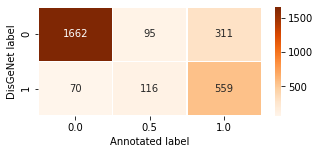

In [308]:
c1, c2 = 'label', 'ann_label'
nc1, nc2 = 'DisGeNet label', 'Annotated label'
tar_s = s_df.groupby([c1, c2])[c2].size()
tar_s.index = tar_s.index.rename([nc1, nc2])

tar_s = tar_s.unstack(level=-1)

fig, ax = plt.subplots(figsize=(5,2)) 
ax = sn.heatmap(tar_s, cmap='Oranges', annot=True, fmt="d", linewidths=.5, ax=ax)

ann_label
0.0    1732
0.5     211
1.0     870
Name: ann_label, dtype: int64


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f5a6449bfd0>],
      dtype=object)

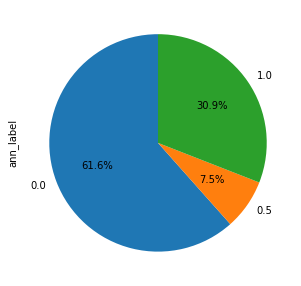

In [309]:
print(s_df.groupby(['ann_label'])['ann_label'].size())
s_df.groupby(['ann_label'])['ann_label'].size().plot(kind='pie', subplots=True, startangle=90,
figsize=(5,5), autopct='%1.1f%%')

In [310]:
# reading 2nd data
raw_data_dir = "../data/ann_table/ann_2nd.tsv"
s_df = pd.read_csv(raw_data_dir, sep='\t', header=0)


In [311]:
s_df['new_label'] = 0.
s_df.loc[pd.isna(s_df['r1_label']), 'new_label'] = s_df[pd.isna(s_df['r1_label'])]['label']
s_df.loc[~pd.isna(s_df['r1_label']), 'new_label'] = s_df[~pd.isna(s_df['r1_label'])]['r1_label']

In [312]:
s_df['ann_label'] = \
s_df.apply(lambda x: 0.5 if (x['new_label'] == 0) and  (x['Have -'] == '1') else x['new_label'], axis=1)

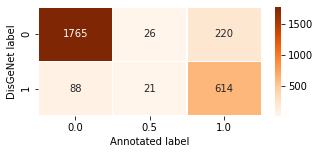

In [317]:
c1, c2 = 'label', 'ann_label'
nc1, nc2 = 'DisGeNet label', 'Annotated label'
tar_s = s_df.groupby([c1, c2])[c2].size()
tar_s.index = tar_s.index.rename([nc1, nc2])

tar_s = tar_s.unstack(level=-1)
fig, ax = plt.subplots(figsize=(5,2)) 
# tar_s = tar_s.transpose()
ax = sn.heatmap(tar_s, cmap='Oranges', annot=True, fmt="d", linewidths=.5, ax=ax)

ann_label
0.0    1853
0.5      47
1.0     834
Name: ann_label, dtype: int64


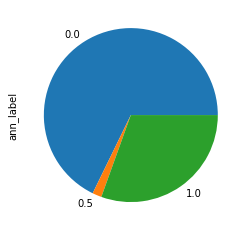

In [194]:
print(s_df.groupby(['ann_label'])['ann_label'].size())
s_df.groupby(['ann_label'])['ann_label'].size().plot(kind='pie')

In [259]:
n1, n2, n3 = 'positivel', 'ambiguous', 'negative'

tar_s1 = s_df1.groupby(['ann_label'])['ann_label'].size()
tar_s1 = tar_s1.rename(index={1: n1, 0.5:n2, 0: n3})
tar_s1 = tar_s1.to_frame()
tar_s1 = tar_s1.rename_axis(None)
tar_s1 = tar_s1.rename(columns={'ann_label': '1st annotated abstract dataset'})

# del tar_s1.index.name

tar_s = s_df.groupby(['ann_label'])['ann_label'].size()
tar_s = tar_s.rename(index={1: n1, 0.5:n2, 0: n3})
tar_s = tar_s.to_frame()
tar_s = tar_s.rename_axis(None)
tar_s = tar_s.rename(columns={'ann_label': '2nd annotated abstract dataset'})


In [264]:
mer_s = tar_s1.merge(tar_s, left_index=True, right_index=True)

In [266]:
mer_s

,1st annotated abstract dataset,2nd annotated abstract dataset
negative,1732,1853
ambiguous,211,47
positivel,870,834


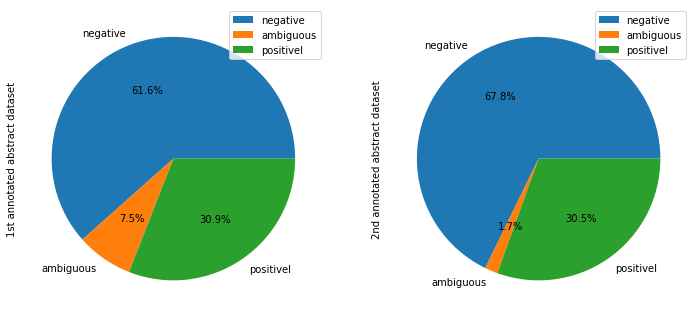

In [284]:
mer_s.plot.pie(subplots=True, figsize=(12, 6), startangle=0,  autopct='%1.1f%%')
plt.show()

In [261]:
tar_s1, tar_s

(           1st annotated abstract dataset
 negative                             1732
 ambiguous                             211
 positivel                             870,
            2nd annotated abstract dataset
 negative                             1853
 ambiguous                              47
 positivel                             834)

/mnt/bal31/jhsu/home/anaconda3/envs/venv/lib/python3.7/site-packages/matplotlib/text.py:1150: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


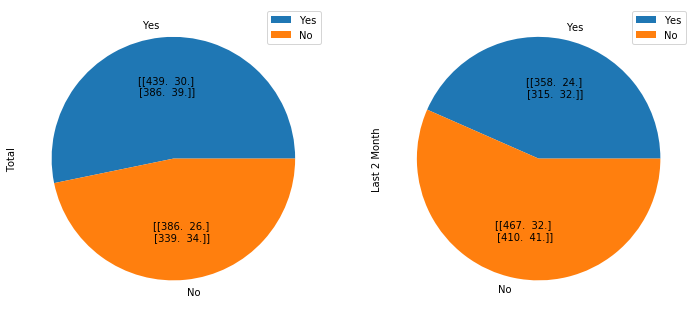

In [214]:
d = {'Yes':pd.Series([825, 56], index=["Total", "Last 2 Month"]), 'No':pd.Series([725, 73], index=["Total", "Last 2 Month"])}
df = pd.DataFrame(d)
df = df.T
def absolute_value(val):
    a  = np.round(val/100.*df.values, 0)
    return a

df.plot.pie(subplots=True, figsize=(12, 6),autopct=absolute_value)
plt.show()

In [215]:
df

,Total,Last 2 Month
Yes,825,56
No,725,73
